In [41]:
# Requirements:
# Reading images to an array
# Feature extraction (transform the image into a fixed-length feature vector)
# Apply any classifier to verify the performance

In [42]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import multiprocessing as mp
from tqdm import tqdm

# For Perceptron
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score


### Reading images to an array

In [43]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
train_file_list = [x.strip() for x in train_file_list]
with open("./val.txt") as f:
    val_file_list = f.readlines()
val_file_list = [x.strip() for x in val_file_list]
with open("./test.txt") as f:
    test_file_list = f.readlines()
test_file_list = [x.strip() for x in test_file_list]

train_file_list = [x.split(sep=" ") for x in train_file_list]
val_file_list = [x.split(sep=" ") for x in val_file_list]
test_file_list = [x.split(sep=" ") for x in test_file_list]

In [44]:
train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

In [45]:
print("# cpus: ", os.cpu_count())

# cpus:  64


In [46]:
NUM_PROCESSES = 8
# pool = mp.Pool(processes=NUM_PROCESSES)

In [47]:
def ReadImage(filePath):
    image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    # image = cv2.resize(image, (256, 256))
    return image

In [48]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

100%|██████████| 450/450 [00:00<00:00, 359648.78it/s]


In [49]:
# the image size is different
for i in range(10):
    print(train_imgs[i].shape)

(256, 343, 3)
(341, 256, 3)
(256, 341, 3)
(256, 341, 3)
(341, 256, 3)
(256, 341, 3)
(256, 256, 3)
(256, 427, 3)
(256, 386, 3)
(384, 256, 3)


In [50]:
# resize the images to 256x256
def ResizeImage(image):
    resized_img = cv2.resize(image, (256, 256))
    return resized_img

In [51]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

100%|██████████| 450/450 [00:00<00:00, 592.27it/s]


0-th image: 


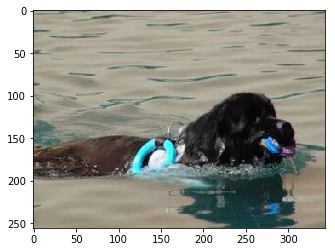

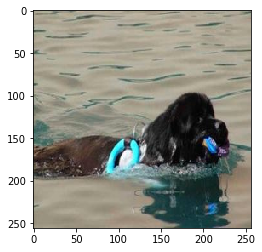

1-th image: 


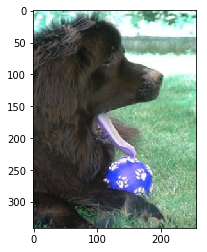

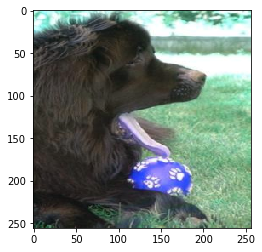

2-th image: 


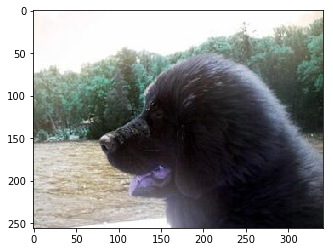

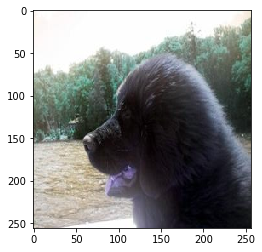

In [52]:
for i in range(3):
    print(f"{i}-th image: ")
    plt.imshow(train_imgs[i])
    plt.show();
    plt.imshow(resized_train_imgs[i])
    plt.show();

### Feature extraction (transform the image into a fixed-length feature vector)

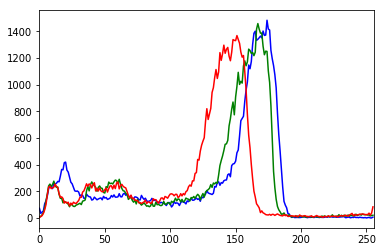

In [53]:
# color histogram
# method: opencv

color = ('b','g','r')
# plt.figure(figsize=(10, 8))
for i,col in enumerate(color):
    histr = cv2.calcHist(images=[resized_train_imgs[0]], channels=[i], mask=None, histSize=[256], ranges=[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0, 256])
plt.show();

In [54]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist(images=[resized_train_imgs[0]], channels=[i], mask=None, histSize=[256], ranges=[0,256])
    print(histr.shape)

(256, 1)
(256, 1)
(256, 1)


In [55]:
resized_train_imgs[0].shape

(256, 256, 3)

In [56]:
resized_train_imgs[0][:, :, 0]

array([[175, 175, 173, ..., 162, 163, 162],
       [169, 170, 170, ..., 128, 120, 113],
       [161, 162, 167, ...,  89,  88,  89],
       ...,
       [157, 155, 158, ..., 131, 131, 130],
       [159, 158, 161, ..., 130, 130, 129],
       [161, 160, 163, ..., 133, 133, 132]], dtype=uint8)

b: 


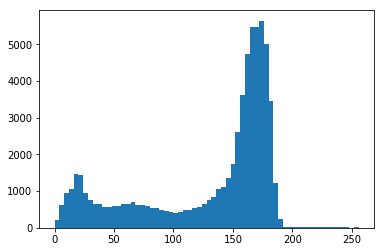

g: 


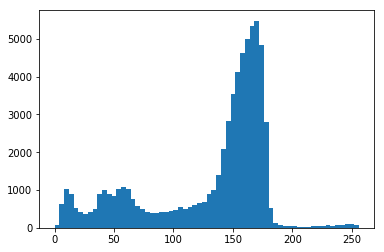

r: 


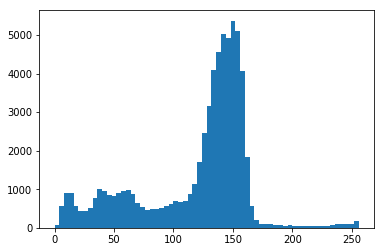

In [57]:
color = ('b', 'g', 'r')
for channel, col in enumerate(color):
    print(f"{col}: ")
    plt.hist(x=resized_train_imgs[0][:, :, channel].ravel(), bins=64, range=[0, 256]);
    plt.show()

In [58]:
# Ref.: https://github.com/Ixiaohuihuihui/Extract-color-histogram-feature/blob/master/rgb_feature.py
# extract rgb features

def ExtractFeatures(image):
    features = []
    for channel in range(3):
        hist = cv2.calcHist(images=[image], channels=[channel], mask=None, histSize=[256], ranges=[0,256])
        hist = cv2.normalize(hist, hist)
        # features.extend(hist)
        features.append(hist)
    return features

In [59]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    ### tqdm returns an iterator
    # train_features = pool.map(ExtractFeatures, tqdm(resized_train_imgs))
    # val_features = pool.map(ExtractFeatures, tqdm(resized_val_imgs))
    # test_features = pool.map(ExtractFeatures, tqdm(resized_test_imgs))
    train_features = list(tqdm(pool.imap(ExtractFeatures, resized_train_imgs), total=len(resized_train_imgs)))
    val_features = list(tqdm(pool.imap(ExtractFeatures, resized_val_imgs), total=len(resized_val_imgs)))
    test_features = list(tqdm(pool.imap(ExtractFeatures, resized_test_imgs), total=len(resized_test_imgs)))

100%|██████████| 450/450 [00:00<00:00, 1009.12it/s]


In [60]:
train_features[0]

[array([[1.02206524e-02],
        [4.82641952e-03],
        [6.24595443e-03],
        [7.38158263e-03],
        [1.50470724e-02],
        [1.81700494e-02],
        [2.32803766e-02],
        [3.09458654e-02],
        [3.43527496e-02],
        [3.30751687e-02],
        [3.12297717e-02],
        [3.66240069e-02],
        [3.63400988e-02],
        [3.69079113e-02],
        [3.88952605e-02],
        [3.84694003e-02],
        [4.45734039e-02],
        [5.16710766e-02],
        [5.12452163e-02],
        [5.89107089e-02],
        [5.94785213e-02],
        [5.09613119e-02],
        [4.88320068e-02],
        [4.34377752e-02],
        [3.80435400e-02],
        [3.63400988e-02],
        [3.25073525e-02],
        [2.88165621e-02],
        [2.83907019e-02],
        [2.86746100e-02],
        [2.75389813e-02],
        [2.32803766e-02],
        [2.45579574e-02],
        [2.41320971e-02],
        [2.08671670e-02],
        [2.07252130e-02],
        [2.54096780e-02],
        [2.35642828e-02],
        [2.2

In [61]:
# type(train_features)
np.array(train_features).shape

(63325, 3, 256, 1)

In [62]:
# flatten and reshape the features into (n_samples, n_features)
train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

def FlattenFeatures(feature):
    return feature.flatten()

with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = np.array(pool.map(FlattenFeatures, tqdm(train_features)))
    val_features = np.array(pool.map(FlattenFeatures, tqdm(val_features)))
    test_features = np.array(pool.map(FlattenFeatures, tqdm(test_features)))

100%|██████████| 450/450 [00:00<00:00, 34090.18it/s]


In [63]:
train_features.shape

(63325, 768)

### Apply any classifier to verify the performance

In [64]:
# Perceptron
perceptron = Perceptron(n_jobs=NUM_PROCESSES, random_state=42)
perceptron.fit(train_features, train_label)

Perceptron(n_jobs=8, random_state=42)

In [67]:
pred_train_label = perceptron.predict(train_features)
pred_val_label = perceptron.predict(val_features)
pred_test_label = perceptron.predict(test_features)

In [68]:
acc_train = accuracy_score(train_label, pred_train_label)
acc_val = accuracy_score(val_label, pred_val_label)
acc_test = accuracy_score(test_label, pred_test_label)

print(f"Accuracy of training set: {acc_train:.4f}")
print(f"Accuracy of validation set: {acc_val:.4f}")
print(f"Accuracy of testing set: {acc_test:.4f}")

Accuracy of training set: 0.0500
Accuracy of validation set: 0.0467
Accuracy of testing set: 0.0378


In [ ]:
# Xgboost


In [ ]:
# NN